# Part 4: Institutions

In this notebook we are going to 

* Load the publications data extracted in part 1
* Focus on institutions linked to a journal: measure how often do they appear, how many affiliated authors they have etc..
* Build some simple visualizations in order to have a quick overview of the results 

## Prerequisites: Installing the Dimensions Library and Logging in

In [2]:

# @markdown # Get the API library and login
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly tqdm -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm as progress

#
# charts libs
# import plotly_express as px
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#
# create output data folder
if not(os.path.exists("data")):
    os.mkdir("data")

DimCli v0.6.7 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


## Institutions Contributing to a Journal

From our original publications dataset, we now want to look at institutions i.e. 

* getting the full list of institutions (also ones without a GRID, for subsequent analysis) linked to the journal
* publications count 
* authors count 

Let's reload the affiliations data from Part-1 of the tutorial.



In [2]:
affiliations = pd.read_csv("data/1.publications_authors_affiliations.csv")
affiliations.head(10)

,aff_id,aff_name,aff_city,aff_city_id,aff_country,aff_country_code,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,grid.38142.3c,Harvard University,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1126819415,NaN,Margaux L. A.,Hujoel
1,grid.38142.3c,Harvard University,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1126819415,NaN,Steven,Gazal
2,grid.66859.34,Broad Institute,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1126819415,NaN,Steven,Gazal
3,grid.66859.34,Broad Institute,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1126819415,NaN,Po-Ru,Loh
4,grid.62560.37,Brigham and Women's Hospital,Boston,4930956.0,United States,US,Massachusetts,US-MA,pub.1126819415,NaN,Po-Ru,Loh
5,grid.66859.34,Broad Institute,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1126819415,NaN,Nick,Patterson
6,grid.38142.3c,Harvard University,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1126819415,NaN,Alkes L.,Price
7,grid.38142.3c,Harvard University,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1126819415,NaN,Alkes L.,Price
8,grid.66859.34,Broad Institute,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1126819415,NaN,Alkes L.,Price
9,grid.89336.37,The University of Texas at Austin,Austin,4671654.0,United States,US,Texas,US-TX,pub.1126821460,NaN,Z. Jeffrey,Chen


## Basic stats about affiliations

* count how many affiliations statements in total
* count how many affiliations have a GRID ID
* count how many unique GRID IDs we have in total

In [7]:
#
# segment the affiliations dataset
affiliations = affiliations.fillna('') 
affiliations_with_grid = affiliations.query("aff_id != ''")
affiliations_without_grid = affiliations.query("aff_id == ''")
#
# save
affiliations_with_grid.to_csv("data/4.Affiliations-with-grid.csv", index=False)
affiliations_without_grid.to_csv("data/4.Affiliations-without-grid.csv", index=False)

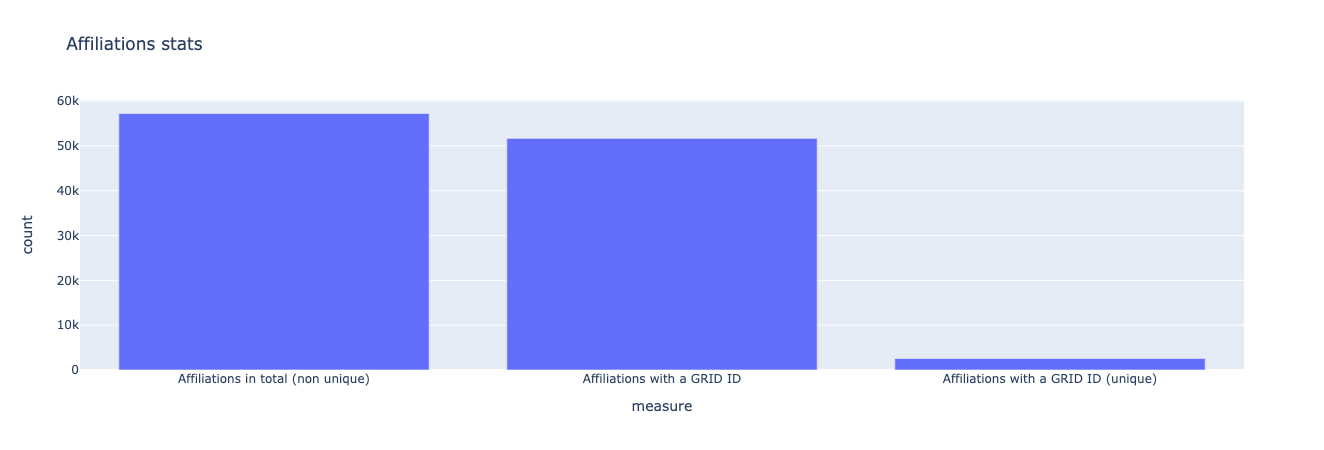

In [8]:
# build a summary barchart

df = pd.DataFrame({
    'measure' : ['Affiliations in total (non unique)', 'Affiliations with a GRID ID', 'Affiliations with a GRID ID (unique)'],
    'count' : [len(affiliations), len(affiliations_with_grid), affiliations_with_grid['aff_id'].nunique()],
})
px.bar(df, x="measure", y="count", title=f"Affiliations stats")

## Enriching the unique affiliations (GRIDs list) with pubs count and authors count

We want a table with the following columns 

* grid ID
* city
* country
* country code
* name
* tot_pubs
* tot_affiliations

NOTE: tot_affiliations is a list of 'authorships' (ie authors in the context of each publication). 

For out analysis we can start from the `gridaffiliations` dataframe. 

In [9]:
affiliations_with_grid.head(5)

,aff_id,aff_name,aff_city,aff_city_id,aff_country,aff_country_code,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,grid.38142.3c,Harvard University,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Margaux L. A.,Hujoel
1,grid.38142.3c,Harvard University,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Steven,Gazal
2,grid.66859.34,Broad Institute,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Steven,Gazal
3,grid.66859.34,Broad Institute,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Po-Ru,Loh
4,grid.62560.37,Brigham and Women's Hospital,Boston,4.93096e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Po-Ru,Loh


In [10]:
gridaffiliations = affiliations_with_grid.copy()
#
# group by GRIDID and add new column with affiliations count
gridaffiliations["tot_affiliations"] = gridaffiliations.groupby('aff_id')['aff_id'].transform('count')
#
# add new column with publications count, for each GRID
gridaffiliations["tot_pubs"] = gridaffiliations.groupby(['aff_id'])['pub_id'].transform('nunique')
# 
# remove unnecessary columns
gridaffiliations = gridaffiliations.drop(['aff_city_id', 'pub_id', 'researcher_id', 'first_name', 'last_name'], axis=1).reset_index(drop=True)
#
# remove duplicate rows
gridaffiliations.drop_duplicates(inplace=True)
#
# update columns order
gridaffiliations = gridaffiliations[[ 'aff_id', 'aff_name','aff_city', 
                                     'aff_country', 'aff_country_code',  'aff_state',
                                     'aff_state_code', 'tot_affiliations',  'tot_pubs']]
#
# sort
gridaffiliations = gridaffiliations.sort_values(['tot_affiliations', 'tot_pubs'], ascending=False)
#
#
# That's it! Let's see the result
gridaffiliations.head()

,aff_id,aff_name,aff_city,aff_country,aff_country_code,aff_state,aff_state_code,tot_affiliations,tot_pubs
2,grid.66859.34,Broad Institute,Cambridge,United States,US,Massachusetts,US-MA,1386,225
0,grid.38142.3c,Harvard University,Cambridge,United States,US,Massachusetts,US-MA,1195,263
295,grid.5335.0,University of Cambridge,Cambridge,United Kingdom,GB,,,931,156
66,grid.10306.34,Wellcome Sanger Institute,Cambridge,United Kingdom,GB,,,702,141
92,grid.32224.35,Massachusetts General Hospital,Boston,United States,US,Massachusetts,US-MA,698,140


In [11]:
# save the data
gridaffiliations.to_csv("data/4.aggregated-affiliations-with-grid.csv", index=False)
# download the data 
if COLAB_ENV:
  files.download("data/4.aggregated-affiliations-with-grid.csv")

## Couple of Dataviz

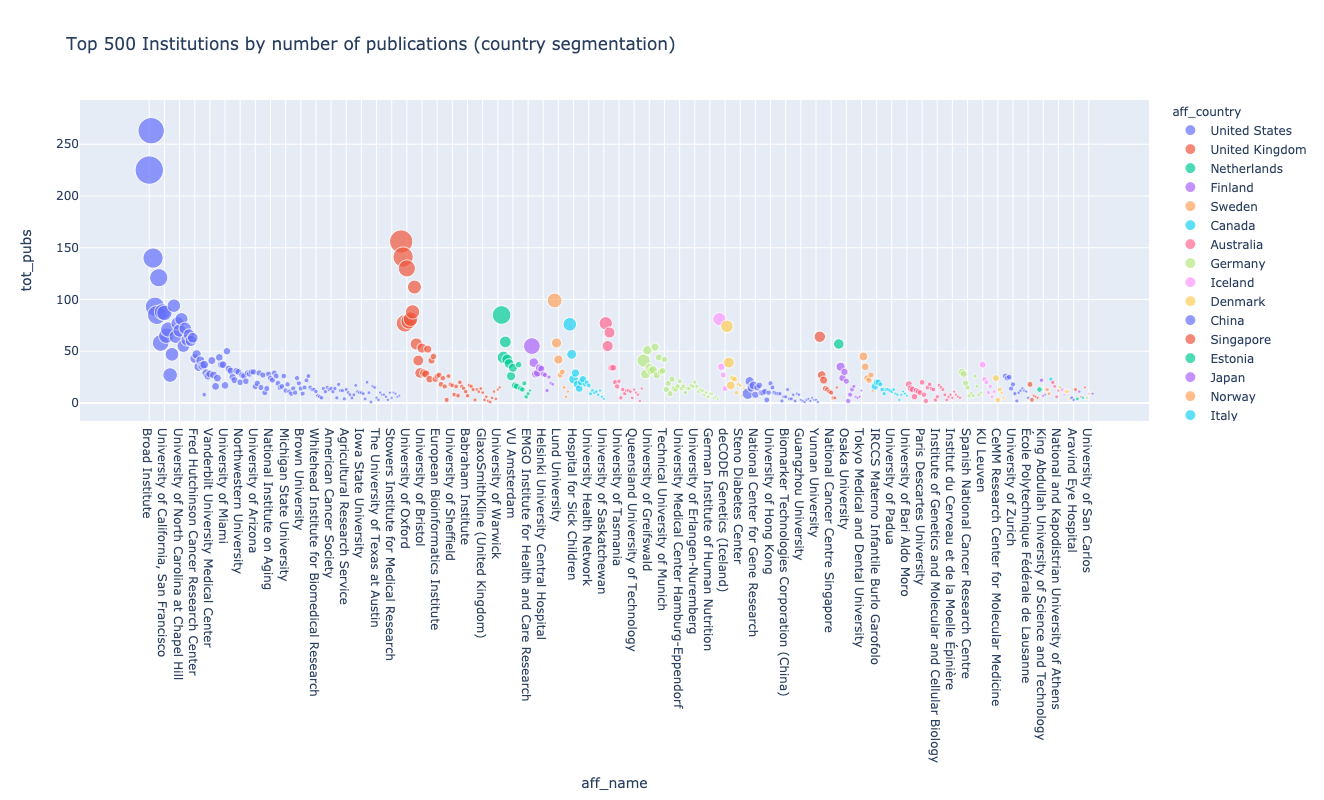

In [20]:
treshold = 500

px.scatter(gridaffiliations[:treshold], 
           x="aff_name", y="tot_pubs", 
           color="aff_country", 
           size='tot_affiliations',
           hover_name="aff_name", 
           height=800,
           hover_data=['aff_id', 'aff_name', 'aff_city', 'aff_country', 'tot_affiliations', 'tot_pubs'], 
           title=f"Top {treshold} Institutions by number of publications (country segmentation)")

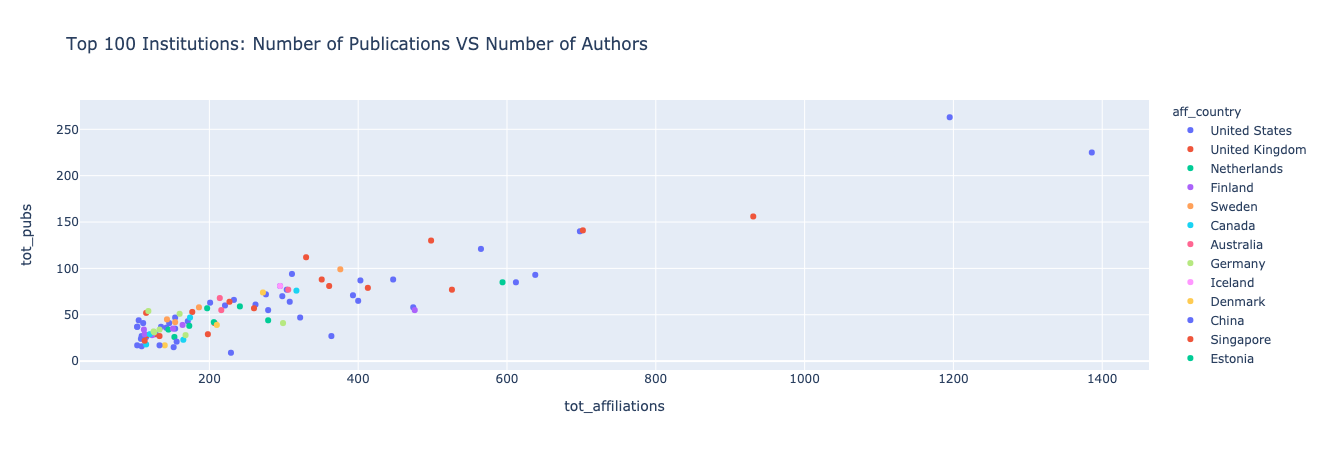

In [22]:
treshold = 100

px.scatter(gridaffiliations[:treshold], 
           x="tot_affiliations", y="tot_pubs", 
           color="aff_country",
           hover_name="aff_name", 
           hover_data=['aff_id', 'aff_name', 'aff_city', 'aff_country', 'tot_affiliations', 'tot_pubs'], 
           title=f"Top {treshold} Institutions: Number of Publications VS Number of Authors")